In [454]:
%pylab inline
from astropy.io import ascii
import os
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS 
import dtdutils
from matplotlib.patches import Rectangle, Circle
from astropy.coordinates import SkyCoord
import clusters_util as cl_util
reload(cl_util)

#Define paths
DTD_path = os.getenv('DTD') + '/'
cluster_path = DTD_path + 'LMC_Star_Clusters/'
plot_path = DTD_path + 'DTD_Plots/'

Populating the interactive namespace from numpy and matplotlib


### Asteca Clusters

In [2]:
#Read the file. Use data_start=3 to avoid reading the '---' separator strings
astec_clusters = ascii.read(cluster_path + 'LMC_Clusters_Asteca.tsv', data_start=3)

#Print the column names for reference
print astec_clusters.colnames

#Only pick out the ones in the LMC
astec_clusters_LMC_full = astec_clusters[astec_clusters['Galaxy']=='LMC']

#Then pick out the ones whose RA's are >60 deg. This is a weird anomaly in the table
#that I have to ask the authors
astec_clusters_LMC = astec_clusters_LMC_full[astec_clusters_LMC_full['RAJ2000']>60.]

#And finally, the ones that are between 1-10 Gyrs
astec_clusters_LMC_1_10_Gyrs = astec_clusters_LMC[astec_clusters_LMC['log(Age)']>=9.]

['Name', 'Galaxy', 'RAJ2000', 'DEJ2000', 'Radius', '[Fe/H]', 'e_[Fe/H]', 'log(Age)', 'e_log(Age)', 'E(B-V)', 'e_E(B-V)', 'mu0', 'emu0', 'Mass', 'e_Mass']


## Looking at the properties of these clusters (age, mass, size, [Fe/H])

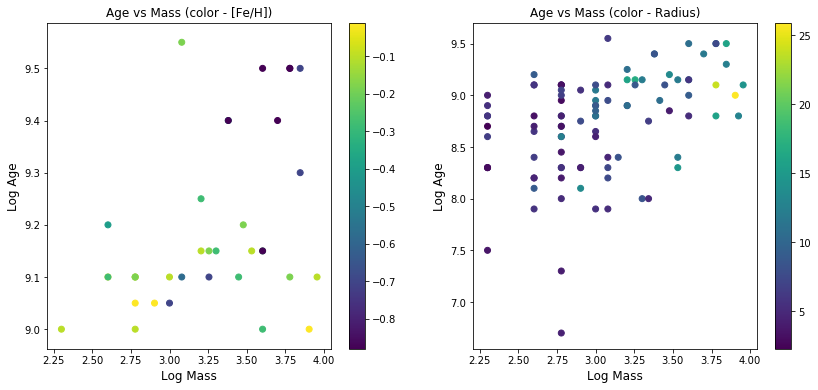

In [71]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.title('Age vs Mass (color - [Fe/H])')
plt.scatter(np.log10(astec_clusters_LMC_1_10_Gyrs['Mass']), \
            astec_clusters_LMC_1_10_Gyrs['log(Age)'], \
            c=astec_clusters_LMC_1_10_Gyrs['[Fe/H]'])
plt.xlabel('Log Mass', fontsize=12)
plt.ylabel('Log Age', fontsize=12)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Age vs Mass (color - Radius)')
plt.scatter(np.log10(astec_clusters_LMC['Mass']), \
            astec_clusters_LMC['log(Age)'], \
            c=astec_clusters_LMC['Radius'])
plt.xlabel('Log Mass', fontsize=12)
plt.ylabel('Log Age', fontsize=12)
plt.colorbar()
plt.savefig(plot_path + 'Astec_Cluster_Properties.png')
plt.show()

RRLyrae in the LMC.
Reading object catalog from file /Users/sumits2k/Desktop/Research/SNResearch2/RadioSNRs/DTD/InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt


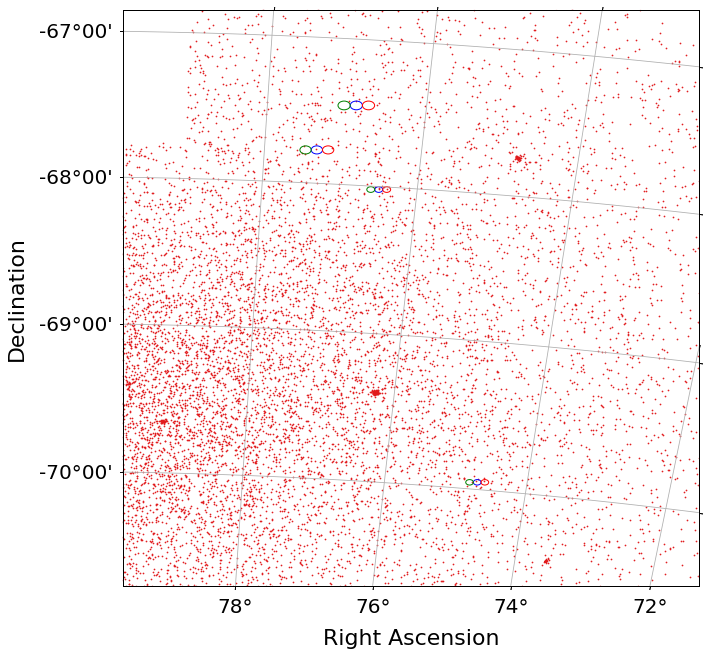

In [82]:
if True:
    fileName = DTD_path + 'InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt'
    firstLine = 7
    lastLine = 24913
    objClassName = 'RRLyrae'
    refName = 'OGLE'
    
obj_subtype = 'All'
objListRA, objListDec = dtdutils.object_ra_decs(fileName, objClassName, obj_subtype=obj_subtype)
astec_clusters_RA = astec_clusters_LMC['RAJ2000']
astec_clusters_Dec = astec_clusters_LMC['DEJ2000']

#~~~~~~~~ Knobs ~~~~~~~~~~~~~~~~~#
save_Plot = True
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#Tutorial on how to use wcsAxes for plotting = http://docs.astropy.org/en/stable/wcs/
#And for adjusting ticks = http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
colors = {'sfh':'#377eb8', 'rrlyrae':'#e41a1c'}

filename = get_pkg_data_filename(DTD_path + 'InputFiles/LMC60.M0NHC.FITS')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
pix_RRL = wcs.wcs_world2pix(15.0*np.asarray(objListRA), np.asarray(objListDec),1)

#Pixel units of each cluster
pix_astec_clusters = wcs.wcs_world2pix(astec_clusters_LMC_1_10_Gyrs['RAJ2000'],\
                                       astec_clusters_LMC_1_10_Gyrs['DEJ2000'],\
                                       1)

#Cluster radius in degrees, for now
cluster_radius = cl_util.pc_to_pixel_radius(astec_clusters_LMC_1_10_Gyrs['Radius'], unit='deg')

#Getting pixels of each cluster, with the declination incremented by the cluster radius
pix_astec_clusters_2 = wcs.wcs_world2pix(astec_clusters_LMC_1_10_Gyrs['RAJ2000'],\
                                         astec_clusters_LMC_1_10_Gyrs['DEJ2000'] + cluster_radius,\
                                       1)

#Radius of each cluster in pixel units
cluster_radius_pix = pix_astec_clusters_2[-1] - pix_astec_clusters[-1]

#Plot the result
fig = plt.figure(figsize = [8., 8.])
fig.add_axes([0., 0., 1., 1.], projection=wcs)
ax = plt.gca()
ax.set_autoscale_on(True)
ax.scatter(pix_RRL[0], pix_RRL[1], edgecolor=colors['rrlyrae'], marker='.', s=2)
#ax.scatter(pix_astec_clusters[0], pix_astec_clusters[1], color='b', marker='o', s=30, alpha=0.6)
#ax.imshow(hdu.data, origin='lower', aspect='equal', cmap='Greys', vmin=1.0e19, vmax=1.0e22) 
#for i in range(cluster_radius_pix.size):
for i in [8, 13, 15, 21]:
    c1 = Circle((pix_astec_clusters[0][i], pix_astec_clusters[1][i]), radius=cluster_radius_pix[i],\
                facecolor='none', edgecolor='b', lw=1.0)
    c2 = Circle((pix_astec_clusters[0][i]+(2.0*cluster_radius_pix[i]), pix_astec_clusters[1][i]),\
                radius=cluster_radius_pix[i], facecolor='none', edgecolor='r', lw=1.0)
    c3 = Circle((pix_astec_clusters[0][i]-(2.0*cluster_radius_pix[i]), pix_astec_clusters[1][i]),\
                radius=cluster_radius_pix[i], facecolor='none', edgecolor='g', lw=1.0)
#    c1 = Circle((astec_clusters_LMC_1_10_Gyrs['RAJ2000'][i], astec_clusters_LMC_1_10_Gyrs['DEJ2000'][i]),\
 #               radius=cluster_radius[i], facecolor='b', edgecolor='b', lw=1.0)
    ax.add_patch(c1)
    ax.add_patch(c2)
    ax.add_patch(c3)
#    ax.add_patch(c12)
[i.set_linewidth(5.0) for i in ax.spines.itervalues()]
ax.coords.grid()#Set this, otherwise the default is to use degrees
ax.coords[0].set_ticklabel(size=20)
ax.coords[0].set_axislabel('Right Ascension', fontsize=22)
ax.coords[1].set_ticklabel(size=20)
ax.coords[1].set_axislabel('Declination', fontsize=22)
#ax.set_xlim(100,2050)  #Set limits are in units of pixels, unlike other functions where you can 
#ax.set_ylim(270,1900)
ax.set_xlim(1000, 1500)
ax.set_ylim(800, 1500)
plt.legend(loc=2, bbox_to_anchor=(0.0, 1.0, 1.0, 0.1), mode='expand', framealpha=1.0, ncol=3, fontsize=15)
if save_Plot:
    plt.savefig(plot_path + 'LMC_Map_RRLyrae_Astec_Clusters.png', bbox_inches='tight')
plt.show()

diam = 2 x radius to pixels()

num_rrl, num_rrl_out = num_rrl_within_rect(ra_cen, dec_cen, diam, average='True')

det_sig = num_rrl/num_rrl_out


In [129]:
n_rrlperCl = np.zeros(cluster_radius.size)
for i in range(cluster_radius.size):
    n_rrlperCl[i] = cl_util.num_rrl_within_box(astec_clusters_LMC_1_10_Gyrs['RAJ2000'][i],\
                             astec_clusters_LMC_1_10_Gyrs['DEJ2000'][i],\
                             cluster_radius[i],\
                             15.0*np.asarray(objListRA), np.asarray(objListDec))
    
idx_ClwithRRL = np.where(n_rrlperCl>0)[0]
for i in idx_ClwithRRL:
    print cl_util.num_rrl_around_box(astec_clusters_LMC_1_10_Gyrs['RAJ2000'][i],\
                             astec_clusters_LMC_1_10_Gyrs['DEJ2000'][i],\
                             cluster_radius[i],\
                             15.0*np.asarray(objListRA), np.asarray(objListDec))

(0, 0, 1, 1, 0, 0, 0, 0)
(1, 0, 0, 1, 0, 0, 1, 1)
(0, 0, 1, 1, 2, 0, 0, 3)
(0, 0, 1, 1, 0, 1, 1, 0)


Questions
1) Is the RA and Dec offset just ra-ra_off, dec-dec_off? Because that wasn't giving me the right size of 
cells for the Harris Zaritsky maps. Is there a possibility of units mismatch?
2) What does Carlos mean by 'use Gaussian or Poisson statistics to determine the density of RRLs in each box'?


In [59]:
np.set_printoptions(threshold=np.inf)
print astec_clusters_LMC_1_10_Gyrs.pprint(max_lines=-1, max_width=-1)

  Name   Galaxy RAJ2000   DEJ2000  Radius [Fe/H] e_[Fe/H] log(Age) e_log(Age) E(B-V) e_E(B-V)  mu0  emu0 Mass e_Mass
-------- ------ -------- --------- ------ ------ -------- -------- ---------- ------ -------- ----- ---- ---- ------
SL73        LMC  73.1875 -72.51778   10.8  -0.28     0.16     9.25       0.08   0.06     0.03 18.58 0.06 1600    500
KMHK229     LMC  73.4625 -69.57194    3.7  -0.01     0.09      9.1       0.09    0.1     0.05 18.56 0.05  400    200
NGC1751     LMC    73.55 -69.80694   14.5   -0.1     0.11      9.1       0.05   0.04     0.03  18.6 0.06 9000   1000
SL96        LMC 73.75417 -67.71417   12.1  -0.28     0.16     9.15       0.05   0.05     0.02 18.56 0.03 2000    500
H88-26      LMC  73.7625 -67.96444    7.5  -0.28     0.22      9.1        0.8    0.0     0.02 18.56 0.03  600    200
SL132       LMC 74.35833 -67.68528    8.2  -0.28     0.16      9.1        0.8   0.06     0.02 18.56 0.06 2800    300
SL133       LMC 74.39167 -65.26778   16.0   -0.7     0.43      9

### Baumgardt 2013 clusters

In [321]:
#Read in tab-separated file
baum_Cl = ascii.read(cluster_path + 'LMC_Massive_Clusters.tsv', data_start=3)

#Print out column names
print baum_Cl.colnames

#Separate old and young clusters 
baum_Cl_10Gyrs = baum_Cl[baum_Cl['logAge']>=10.]
baum_Cl_1_10Gyrs = baum_Cl[(baum_Cl['logAge']<=10.) & (baum_Cl['logAge']>=9.)]

#Sizes of old clusters
baum_Cl_10Gyrs_sizes = np.fromiter([cl_util.size_from_Bica_catalog(name.replace(' ', ''))\
                                    for name in baum_Cl_10Gyrs['Name']], dtype=float)

#Extract RA/Dec in degrees from the format in the file
baum_Cl_10Gyrs_ra, baum_Cl_10Gyrs_dec = cl_util.cluster_ra_dec(baum_Cl_10Gyrs['RAJ2000'], baum_Cl_10Gyrs['DEJ2000'])

#Sizes of young clusters
baum_Cl_1_10Gyrs_sizes = np.fromiter([cl_util.size_from_Bica_catalog(name.replace(' ', ''))\
                                    for name in baum_Cl_1_10Gyrs['Name']], dtype=float)

#Extract RA/Dec in degrees from the format in the file
baum_Cl_1_10Gyrs_ra, baum_Cl_1_10Gyrs_dec = cl_util.cluster_ra_dec(baum_Cl_1_10Gyrs['RAJ2000'], \
                                                                   baum_Cl_1_10Gyrs['DEJ2000'])

['Name', 'RAJ2000', 'DEJ2000', 'VMAG', 'logAge', 'e_logAge', 'logM', 'Ref', 'OName', 'SimbadName']


### Bica Clusters (for size information)

RRLyrae in the LMC.
Reading object catalog from file /Users/sumits2k/Desktop/Research/SNResearch2/RadioSNRs/DTD/InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt


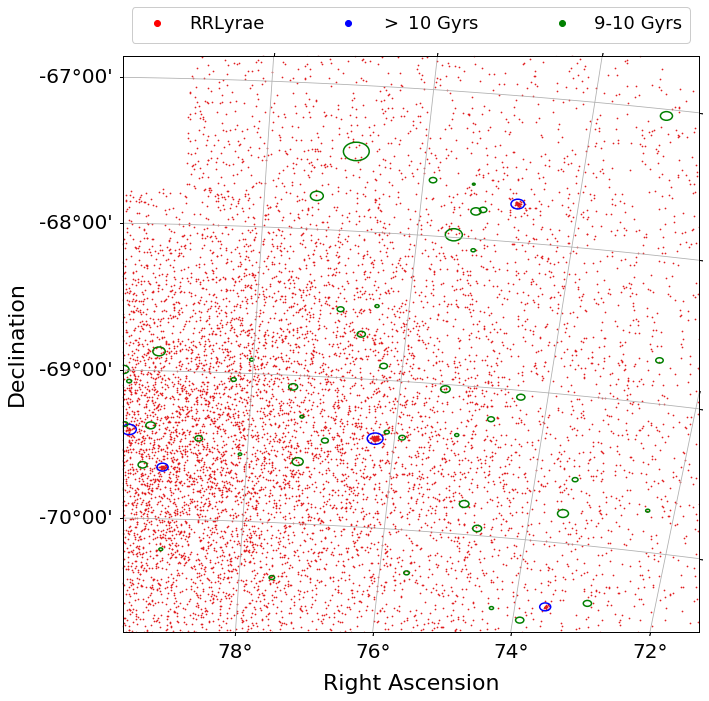

In [442]:
if True:
    fileName = DTD_path + 'InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt'
    firstLine = 7
    lastLine = 24913
    objClassName = 'RRLyrae'
    refName = 'OGLE'
    
obj_subtype = 'All'
objListRA, objListDec = dtdutils.object_ra_decs(fileName, objClassName, obj_subtype=obj_subtype)
astec_clusters_RA = astec_clusters_LMC['RAJ2000']
astec_clusters_Dec = astec_clusters_LMC['DEJ2000']

#~~~~~~~~ Knobs ~~~~~~~~~~~~~~~~~#
save_Plot = True
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#Tutorial on how to use wcsAxes for plotting = http://docs.astropy.org/en/stable/wcs/
#And for adjusting ticks = http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
colors = {'sfh':'#377eb8', 'rrlyrae':'#e41a1c'}

filename = get_pkg_data_filename(DTD_path + 'InputFiles/LMC60.M0NHC.FITS')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
pix_RRL = wcs.wcs_world2pix(15.0*np.asarray(objListRA), np.asarray(objListDec),1)

#~~~~~~~~~~~~~~~ OLDER CLUSTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#Pixel units of each cluster
pix_clusters = wcs.wcs_world2pix(baum_Cl_10Gyrs_ra, baum_Cl_10Gyrs_dec, 1)

#Getting pixels of each cluster, with the declination incremented by the cluster radius
pix_clusters_2 = wcs.wcs_world2pix(baum_Cl_10Gyrs_ra, baum_Cl_10Gyrs_dec + baum_Cl_10Gyrs_sizes, 1)

#Radius of each cluster in pixel units
cluster_radius_pix = pix_clusters_2[-1] - pix_clusters[-1]

#~~~~~~~~~~~~~~~ YOUNGER CLUSTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#Pixel units of each cluster
pix_clusters_yng = wcs.wcs_world2pix(baum_Cl_1_10Gyrs_ra, baum_Cl_1_10Gyrs_dec, 1)

#Getting pixels of each cluster, with the declination incremented by the cluster radius
pix_clusters_2_yng = wcs.wcs_world2pix(baum_Cl_1_10Gyrs_ra, baum_Cl_1_10Gyrs_dec + baum_Cl_1_10Gyrs_sizes, 1)

#Radius of each cluster in pixel units
cluster_radius_pix_yng = pix_clusters_2_yng[-1] - pix_clusters_yng[-1]

#Plot the result
fig = plt.figure(figsize = [8., 8.])
fig.add_axes([0., 0., 1., 1.], projection=wcs)
ax = plt.gca()
ax.set_autoscale_on(True)
ax.scatter(pix_RRL[0], pix_RRL[1], edgecolor=colors['rrlyrae'], marker='.', s=2)
ax.plot([],[], 'ro', label='RRLyrae')
#ax.plot(pix_clusters_yng[0], pix_clusters_yng[1], 'g.')
#ax.scatter(pix_astec_clusters[0], pix_astec_clusters[1], color='b', marker='o', s=30, alpha=0.6)
#ax.imshow(hdu.data, origin='lower', aspect='equal', cmap='Greys', vmin=1.0e19, vmax=1.0e22) 
#for i in range(cluster_radius_pix.size):
for i in range(cluster_radius_pix.size):
    if (baum_Cl_10Gyrs_ra[i]>=72.) & (baum_Cl_10Gyrs_ra[i] <=80.):
  #  if True:
        c1 = Circle((pix_clusters[0][i], pix_clusters[1][i]), radius=cluster_radius_pix[i],\
                    facecolor='none', edgecolor='b', lw=1.5)

        ax.add_patch(c1)
#        ax.text(pix_clusters[0][i]+10, pix_clusters[1][i]+10, baum_Cl_10Gyrs['Name'][i], fontsize=11,\
#                fontweight='bold')
ax.plot([],[],'bo', label=r'$>$ 10 Gyrs')        
for i in range(cluster_radius_pix_yng.size):
    if (baum_Cl_1_10Gyrs_ra[i]>=72.) & (baum_Cl_1_10Gyrs_ra[i] <=80.):
  #  if True:
        c2 = Circle((pix_clusters_yng[0][i], pix_clusters_yng[1][i]), radius=cluster_radius_pix_yng[i],\
                    facecolor='none', edgecolor='g', lw=1.5)

        ax.add_patch(c2)
#        ax.text(pix_clusters_yng[0][i]+5, pix_clusters_yng[1][i]+5, baum_Cl_1_10Gyrs['Name'][i], fontsize=11,\
#                fontweight='bold')
plt.plot([],[],'go',label=r'9-10 Gyrs')  
#    ax.add_patch(c12)
ax.coords.grid()#Set this, otherwise the default is to use degrees
ax.coords[0].set_ticklabel(size=20)
ax.coords[0].set_axislabel('Right Ascension', fontsize=22)
ax.coords[1].set_ticklabel(size=20)
ax.coords[1].set_axislabel('Declination', fontsize=22)
#ax.set_xlim(100,1900)  #Set limits are in units of pixels, unlike other functions where you can 
#ax.set_ylim(270,1900)
ax.set_xlim(1000, 1500)
ax.set_ylim(800, 1500)
plt.legend(loc=2, bbox_to_anchor=(0.0, 1.0, 1.0, 0.1), mode='expand', framealpha=1.0, ncol=3, fontsize=18)
if save_Plot:
    plt.savefig(plot_path + 'LMC_Map_RRLyrae_Baum13_Old_Young_Clusters_Zoomed.png', bbox_inches='tight')
plt.show()

In [458]:
n_rrlperCl = np.zeros(len(baum_Cl_10Gyrs))
n_backgr_perCell = np.zeros((len(baum_Cl_10Gyrs), 8))
for i in range(len(baum_Cl_10Gyrs)):
    n_rrlperCl[i] = cl_util.num_rrl_within_box(baum_Cl_10Gyrs_ra[i], baum_Cl_10Gyrs_dec[i],\
                                               baum_Cl_10Gyrs_sizes[i],\
                                               15.0*np.asarray(objListRA), np.asarray(objListDec))
    
    n_backgr_perCell[i] = cl_util.num_rrl_around_box(baum_Cl_10Gyrs_ra[i], baum_Cl_10Gyrs_dec[i],\
                                               baum_Cl_10Gyrs_sizes[i],\
                                               15.0*np.asarray(objListRA), np.asarray(objListDec))

cl_util.write_cluster_rrl_table(baum_Cl_10Gyrs['Name'], baum_Cl_10Gyrs_ra, baum_Cl_10Gyrs_dec,\
                        baum_Cl_10Gyrs['logAge'], baum_Cl_10Gyrs['logM'], baum_Cl_10Gyrs_sizes,\
                        n_rrlperCl, n_backgr_perCell, cluster_path + 'LMC_RRL_per_Clust_10Gyrs.dat')

Clusters with a significant RRL population


Names -       Name    
-------------
NGC1754      
NGC1786      
NGC1835      
NGC1898      
NGC1916      
NGC2005      
NGC2019      
NGC2210      
Number of RRLs -  N_RRL
-----
 30.0
 47.0
 93.0
 39.0
 16.0
 15.0
 49.0
 54.0
Significance (Nsigma) -  Det_Sig
-------
  30.98
  30.74
  47.04
  19.36
   4.47
   9.58
  25.42
  49.89


In [457]:
n_rrlperCl = np.zeros(len(baum_Cl_1_10Gyrs))
n_backgr_perCell = np.zeros((len(baum_Cl_1_10Gyrs), 8))
for i in range(len(baum_Cl_1_10Gyrs)):
    n_rrlperCl[i] = cl_util.num_rrl_within_box(baum_Cl_1_10Gyrs_ra[i], baum_Cl_1_10Gyrs_dec[i],\
                                               1.0*baum_Cl_1_10Gyrs_sizes[i],\
                                               15.0*np.asarray(objListRA), np.asarray(objListDec))
    
    n_backgr_perCell[i] = cl_util.num_rrl_around_box(baum_Cl_1_10Gyrs_ra[i], baum_Cl_1_10Gyrs_dec[i],\
                                               1.0*baum_Cl_1_10Gyrs_sizes[i],\
                                               15.0*np.asarray(objListRA), np.asarray(objListDec))
    
cl_util.write_cluster_rrl_table(baum_Cl_1_10Gyrs['Name'], baum_Cl_1_10Gyrs_ra, baum_Cl_1_10Gyrs_dec,\
                        baum_Cl_1_10Gyrs['logAge'], baum_Cl_1_10Gyrs['logM'], baum_Cl_1_10Gyrs_sizes,\
                        n_rrlperCl, n_backgr_perCell, cluster_path + 'LMC_RRL_per_Clust_1_10Gyrs.dat')

Clusters with a significant RRL population


Names -       Name    
-------------
HS35         
HS37         
SL151        
H88-93       
SL180        
HS117        
NGC1928      
KMHK1112     
Number of RRLs -  N_RRL
-----
  1.0
  1.0
  2.0
  1.0
  3.0
  3.0
  7.0
  1.0
Significance (Nsigma) -  Det_Sig
-------
    inf
    inf
   2.61
    inf
   4.23
   2.59
   2.85
    inf


clusters_util.py:25: RuntimeWarning: divide by zero encountered in divide
  rrlTable['Det_Sig'] = np.around(np.absolute((rrlTable['N_RRL'] - rrlTable['N_back']))/rrlTable['s_back'],\
clusters_util.py:25: RuntimeWarning: invalid value encountered in divide
  rrlTable['Det_Sig'] = np.around(np.absolute((rrlTable['N_RRL'] - rrlTable['N_back']))/rrlTable['s_back'],\
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


In [398]:
write_cluster_rrl_table(baum_Cl_1_10Gyrs['Name'], baum_Cl_1_10Gyrs_ra, baum_Cl_1_10Gyrs_dec,\
                        baum_Cl_1_10Gyrs['logAge'], baum_Cl_1_10Gyrs['logM'], baum_Cl_1_10Gyrs_sizes,\
                        n_rrlperCl, n_backgr_perCell, cluster_path + 'LMC_RRL_per_Clust_1_10Gyrs.dat')

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in divide
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


In [449]:
1.2*1.4


1.68